# Extract OSM road-network detailed

Code for extracting and storing the simplified and detailed OSM road-network.

Process is load from OSMN, convert to data-frames, remove non-highway entities, store results as geojson.

Results can then be combined back into Networkx graph.

In [41]:
%reload_kedro
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False
import geopandas as gpd
import networkx as nx
import osmnx as ox
import pandas as pd

from utils.process_gdf import process_edges

2022-04-05 13:46:30,531 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-05 13:46:30,619 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-04-05 13:46:30,620 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-05 13:46:30,629 - root - INFO - Registered line magic `run_viz`
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Cape Town sample road-network

The following custom filter works for Singapore, given that its road network is quite porous. 

It seems to return non-highway boundaries and entities, which is a problem.

A subsample of the full network is loaded for test purposes:

In [42]:
city = "City of Cape Town"

In [43]:
drive_service_all = '["area"!~"yes"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|corridor|elevator|escalator|proposed|construction|bridleway|abandoned|platform|raceway"]["motor_vehicle"!~"no"]["motorcar"!~"no"]'
exclude_emergency_services = '["service"!~"emergency_access"]'
exclude_custom_services = (
    '["access"!~"private"]["service"!~"parking|parking_aisle|private|emergency_access"]'
)
exclude_parking_private_emergency = (
    '["access"!~"private"]["service"!~"parking|private|emergency_access"]'
)
exclude_private = '["access"!~"private"]["service"!~"private"]'
custom_filter = drive_service_all + exclude_emergency_services

It relies too much on `["motor_vehicle"!~"no"]["motorcar"!~"no"]`. Easiest way to filter roads seem to be to use high-way.

In [44]:
custom_filter

'["area"!~"yes"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|corridor|elevator|escalator|proposed|construction|bridleway|abandoned|platform|raceway"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"emergency_access"]'

In [45]:
gap_zones = catalog.load("gap_zones")
gap_zones_sample = gap_zones.loc[gap_zones["OBJECTID"].isin([24645])]
geometry = gap_zones_sample.geometry.values[0]

2022-04-05 13:46:31,862 - kedro.io.data_catalog - INFO - Loading data from `gap_zones` (GeoJSONDataSet)...


In [46]:
%%time
G_full = ox.graph_from_polygon(geometry, custom_filter=custom_filter, simplify=False)

CPU times: user 17.4 s, sys: 319 ms, total: 17.8 s
Wall time: 18.1 s


### Write files

In [47]:
catalog.save("road_network_full_24645", G_full)

2022-04-05 13:46:50,125 - kedro.io.data_catalog - INFO - Saving data to `road_network_full_24645` (NetworkXDataSet)...


## Unpack road elements

In [48]:
G_full = catalog.load("road_network_full_24645")
node_list_full, edge_list_full = ox.graph_to_gdfs(G_full)
node_list_full = node_list_full.reset_index()
edge_list_full = edge_list_full.reset_index()
node_list_full_xy = node_list_full.to_crs("EPSG:3414").reset_index()
edge_list_full_xy = edge_list_full.to_crs("EPSG:3414").reset_index()

2022-04-05 13:46:52,465 - kedro.io.data_catalog - INFO - Loading data from `road_network_full_24645` (NetworkXDataSet)...


In [49]:
node_list_full["index"] = node_list_full["osmid"]
node_list_full_xy["index"] = node_list_full_xy["osmid"]

Remove non-highway tags:

In [50]:
def filter_highway(nodes, edges):
    print("BEFORE:", nodes.shape, edges.shape)
    edges = edges.copy()
    nodes = nodes.copy()
    nodes["u"] = nodes["index"]
    edges = edges.loc[~edges["highway"].isna()]
    nodes = nodes.loc[(nodes["u"].isin(edges["u"])) | (nodes["u"].isin(edges["v"]))]
    print("AFTER:", nodes.shape, edges.shape)
    return nodes, edges


nodes_list_full, edges_list_full = filter_highway(node_list_full, edge_list_full)
node_list_full_xy, edge_list_full_xy = filter_highway(
    node_list_full_xy, edge_list_full_xy
)

BEFORE: (33698, 8) (67687, 19)
AFTER: (26012, 9) (48947, 19)
BEFORE: (33698, 8) (67687, 20)
AFTER: (26012, 9) (48947, 20)


### Write files

In [51]:
%reload_kedro
catalog.save("road_network_full_24645_nodes", node_list_full)
catalog.save("road_network_full_24645_edges", edge_list_full)
catalog.save("road_network_full_24645_nodes_xy", node_list_full_xy)
catalog.save("road_network_full_24645_edges_xy", edge_list_full_xy)

2022-04-05 13:47:03,326 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-05 13:47:03,423 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-04-05 13:47:03,425 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-05 13:47:03,434 - root - INFO - Registered line magic `run_viz`
2022-04-05 13:47:03,436 - kedro.io.data_catalog - INFO - Saving data to `road_network_full_24645_nodes` (GeoJSONDataSet)...
2022-04-05 13:47:06,364 - kedro.io.data_catalog - INFO - Saving data to `road_network_full_24645_edges` (GeoJSONDataSet)...
2022-04-05 13:47:18,175 - kedro.io.data_catalog - INFO - Saving data to `road_network_full_24645_nodes_xy` (GeoJSONDataSet)...
2022-04-05 13:47:20,488 - kedro.io.data_catalog - INFO - Saving data to `road_network_full_24645_edges_xy` (GeoJSONDataSet)...


## Load and save simplified road network

In [52]:
%%time
G_simplified = ox.graph_from_polygon(
    geometry, custom_filter=custom_filter, simplify=True
)

CPU times: user 14.8 s, sys: 208 ms, total: 15 s
Wall time: 15.2 s


### Write file

In [53]:
%reload_kedro
# catalog.save("road_network_simplified_24645", G_simplified)
# DataSetError: Failed while saving data to data set NetworkXDataSet(filepath=/Users/ejwillemse/dev/waste_labs_dev/project_rdi_cpt/data/02_intermediate/road_network/road_network_simplified_24645.json, load_args={}, protocol=file, save_args={}).
# Object of type LineString is not JSON serializable

2022-04-05 13:47:44,684 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-05 13:47:44,794 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-04-05 13:47:44,796 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-05 13:47:44,805 - root - INFO - Registered line magic `run_viz`


In [54]:
node_list, edge_list = ox.graph_to_gdfs(G_simplified)
node_list = node_list.reset_index()
edge_list = edge_list.reset_index()
node_list_xy = node_list.to_crs("EPSG:3414")
edge_list_xy = edge_list.to_crs("EPSG:3414")

In [55]:
node_list["index"] = node_list["osmid"]
node_list_xy["index"] = node_list_xy["osmid"]

In [56]:
nodes_list_full, edges_list_full = filter_highway(node_list, edge_list)
node_list_full_xy, edge_list_full_xy = filter_highway(node_list_xy, edge_list_xy)

BEFORE: (8145, 8) (22189, 19)
AFTER: (7093, 9) (16777, 19)
BEFORE: (8145, 8) (22189, 19)
AFTER: (7093, 9) (16777, 19)


<AxesSubplot:>

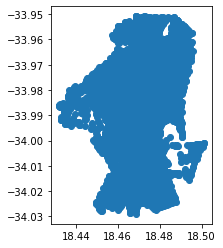

In [57]:
node_list.plot()

<AxesSubplot:>

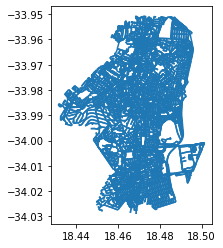

In [58]:
edge_list.plot()

In [59]:
for c in edge_list.columns:
    edge_list[c] =  edge_list[c].apply(lambda x: ",".join([str(y) for y in x]) if type(x) == list else x)

In [60]:
for c in edge_list_xy.columns:
    edge_list_xy[c] =  edge_list_xy[c].apply(lambda x: ",".join([str(y) for y in x]) if type(x) == list else x)

## Write files

In [61]:
%reload_kedro
catalog.save("road_network_simplified_24645_nodes", node_list)
catalog.save("road_network_simplified_24645_edges", edge_list)
catalog.save("road_network_simplified_24645_nodes_xy", node_list_xy)
catalog.save("road_network_simplified_24645_edges_xy", edge_list_xy)

2022-04-05 13:47:52,577 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-05 13:47:52,675 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-04-05 13:47:52,676 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-05 13:47:52,685 - root - INFO - Registered line magic `run_viz`
2022-04-05 13:47:52,687 - kedro.io.data_catalog - INFO - Saving data to `road_network_simplified_24645_nodes` (GeoJSONDataSet)...
2022-04-05 13:47:53,345 - kedro.io.data_catalog - INFO - Saving data to `road_network_simplified_24645_edges` (GeoJSONDataSet)...
2022-04-05 13:47:57,009 - kedro.io.data_catalog - INFO - Saving data to `road_network_simplified_24645_nodes_xy` (GeoJSONDataSet)...
2022-04-05 13:47:57,672 - kedro.io.data_catalog - INFO - Saving data to `road_network_simplified_24645_edges_xy` (GeoJSONDataSet)...


## Save simplified directed edge list


Requires external libraries:

In [62]:
edge_list_xy_direct = process_edges(edge_list_xy)
edge_list_xy_direct = edge_list_xy_direct.drop_duplicates(["geom_id_order"])
edge_list_xy_direct.shape

(11173, 23)

In [63]:
edge_list.shape

(22189, 19)

In [64]:
edge_list_direct = process_edges(edge_list)
edge_list_direct = edge_list_direct.drop_duplicates(["geom_id_order"])
edge_list_direct.shape

(11173, 23)

### Write file

In [65]:
%reload_kedro
catalog.save("road_network_simplified_24645_edges_directed", edge_list_direct)
catalog.save("road_network_simplified_24645_edges_xy_directed", edge_list_xy_direct)

2022-04-05 13:48:03,601 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-05 13:48:03,704 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-04-05 13:48:03,706 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-05 13:48:03,717 - root - INFO - Registered line magic `run_viz`
2022-04-05 13:48:03,718 - kedro.io.data_catalog - INFO - Saving data to `road_network_simplified_24645_edges_directed` (CSVDataSet)...
2022-04-05 13:48:04,054 - kedro.io.data_catalog - INFO - Saving data to `road_network_simplified_24645_edges_xy_directed` (CSVDataSet)...


## ANNEX: Future code for converting back into Graph

In [ ]:
node_list_full = gpd.GeoDataFrame(node_list_full, geometry="geometry", crs="EPSG:4326")
node_list_full = node_list_full.set_index("index")
edge_list_full = gpd.GeoDataFrame(edge_list_full, geometry="geometry", crs="EPSG:4326")

edge_list_full = edge_list_full.set_index(["u", "v", "key"])

G_full_red = ox.graph_from_gdfs(
    node_list_full,
    edge_list_full,
)

In [ ]:
len([node for node in G_full_red.nodes if type(node) is not dict])